Outage/Census Data geodataframe is now aggregated by block group centroids and ready to use in seaborn/DBSCAN

In [83]:
#Originally manipulated the data in python to find the centroid for each block group which includes the following:
#total power outage complaints, total population, median household income, power outage complaints per 10K people

#Had to go into ArcMap to add the xy event layer..not sure how to extract x and y values from geodataframe 'geometry' 
#column in python
NYCoutagewpop_NANfilewithlatandlong = gpd.read_file(r'C:\Users\CHerbert\Downloads\GeoComp2\ElectricalOutageProject\RawData_PowerOutageProjectbyblkgrp\ACS2018NYCbyblkgrp_outage_onlyintersectselectfields_Arcdissolve_blkgrpCENTROIDSandrateremoveNAN.shp')


import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import numpy as np
from shapely.geometry import Point

import seaborn as sn

from sklearn.cluster import DBSCAN 
from sklearn.preprocessing import StandardScaler 
from sklearn.preprocessing import normalize 
from sklearn.decomposition import PCA

In [84]:
#extracting lat, long 
#columns into a numpy matrix of coordinates (these will be normalized when I use minmax scalar)
xs,ys = np.asarray(NYCoutagewpop_NANfilewithlatandlong.Long), np.asarray(NYCoutagewpop_NANfilewithlatandlong.Lat)
NYCoutagewpop_NANfilewithlatandlong['xm']= xs.tolist() 
NYCoutagewpop_NANfilewithlatandlong['ym'] =ys.tolist()

#How do I tie data back to original geometry after normalizing and clustering??
#minmaxscalar did not accept extra columns in dataframe that I wasn't normalizing
#I tried adding a second numpy matrix of coordinates (NOT to be normalized and will continue to tie data to original geometry
#coordinate numbers when I go to convert dataframe to geodataframe after clustering
#extracting lat, long 
#columns into a second numpy matrix of coordinates (these will NOT be normalized and will continue to tie data to original 
#coordinate numbers when I go to convert dataframe to geodataframe after clustering

#x1s,y1s = np.asarray(NYCoutagewpop_NANfilewithlatandlong.Long), np.asarray(NYCoutagewpop_NANfilewithlatandlong.Lat)
#NYCoutagewpop_NANfilewithlatandlong['x1m']= x1s.tolist() 
#NYCoutagewpop_NANfilewithlatandlong['y1m'] =y1s.tolist()
NYCoutagewpop_NANfilewithlatandlong.head()

,STATEFP,COUNTYFP,TRACTCE,BLKGRPCE,GEOID,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,...,SUM_Outage,Total_Popu,MedianHHIn,MedHHInc_I,Out_Rate_1,Lat,Long,geometry,xm,ym
0,36,005,023900,5,360050239005,Block Group 5,G5030,S,19403.0,0.0,...,2.0,694.0,32902,32902.0,28.818444,252425.826948,1.011175e+06,POINT (1011174.992 252425.827),1.011175e+06,252425.826948
1,36,005,024100,4,360050241004,Block Group 4,G5030,S,14808.0,0.0,...,13.0,692.0,38095,38095.0,187.861272,249805.382494,1.010310e+06,POINT (1010309.801 249805.382),1.010310e+06,249805.382494
2,36,005,024100,5,360050241005,Block Group 5,G5030,S,20191.0,0.0,...,15.0,2081.0,37768,37768.0,72.080730,250401.497982,1.010719e+06,POINT (1010719.462 250401.498),1.010719e+06,250401.497982
3,36,005,024501,2,360050245012,Block Group 2,G5030,S,28740.0,0.0,...,10.0,1487.0,32938,32938.0,67.249496,250261.369159,1.007228e+06,POINT (1007228.282 250261.369),1.007228e+06,250261.369159
4,36,005,026300,4,360050263004,Block Group 4,G5030,S,15413.0,0.0,...,6.0,936.0,61378,61378.0,64.102564,254432.931399,1.010397e+06,POINT (1010397.270 254432.931),1.010397e+06,254432.931399


Isolating only the columns to be normalized and clustered..I also wanted to keep 'geometry' column but scalar said 'float argument mnust be string or number not point'

In [85]:
NYCoutagewpop_NANfilewithlatandlong_select=NYCoutagewpop_NANfilewithlatandlong[['Out_Rate_1','MedHHInc_I','xm','ym']]

Next 5 cells show the distribution, min, and max for the 4 data columns to be normalized and clustered

In [88]:
NYCoutagewpop_NANfilewithlatandlong_select.describe()

,Out_Rate_1,MedHHInc_I,xm,ym
count,4459.000000,4459.000000,4.459000e+03,4459.000000
mean,52.242762,66920.528818,1.007150e+06,203666.155770
std,82.383260,35546.924299,2.261885e+04,31424.099627
min,2.115059,9234.000000,9.146257e+05,123039.098269
25%,13.896931,42591.500000,9.943623e+05,180396.082041
50%,30.888031,60943.000000,1.006272e+06,198818.485234
75%,65.156228,82992.000000,1.020698e+06,229099.769700
max,3069.544365,250000.000000,1.066274e+06,271104.638804


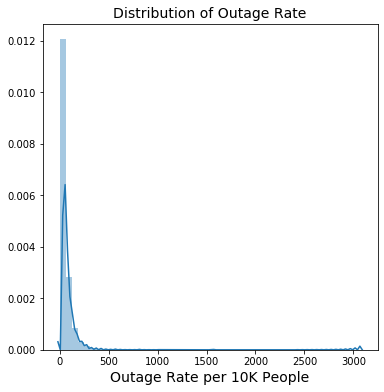

In [86]:
sn.distplot(NYCoutagewpop_NANfilewithlatandlong_select['Out_Rate_1'])

plt.rcParams["figure.figsize"] = (6,6)

plt.xlabel('Outage Rate per 10K People', fontsize=14)
plt.title("Distribution of Outage Rate", fontsize=14)
plt.show()


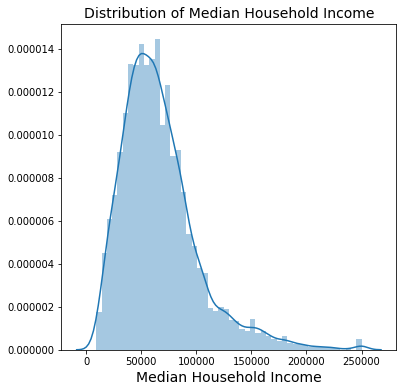

In [8]:
sn.distplot(NYCoutagewpop_NANfilewithlatandlong_select['MedHHInc_I'])


plt.xlabel('Median Household Income', fontsize=14)
plt.title("Distribution of Median Household Income", fontsize=14)
plt.show()

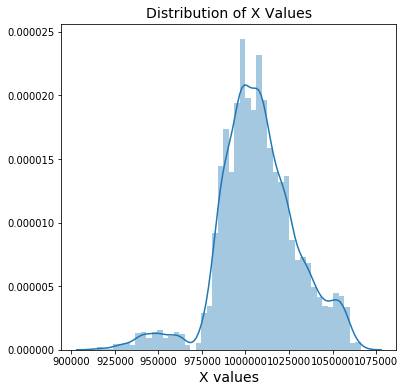

In [9]:
sn.distplot(NYCoutagewpop_NANfilewithlatandlong_select['xm'])


plt.xlabel('X values', fontsize=14)
plt.title("Distribution of X Values", fontsize=14)
plt.show()

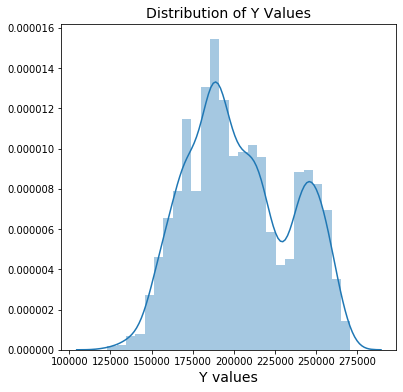

In [10]:
sn.distplot(NYCoutagewpop_NANfilewithlatandlong_select['ym'])


plt.xlabel('Y values', fontsize=14)
plt.title("Distribution of Y Values", fontsize=14)
plt.show()

Used minmax scalar and robustscalar on the 4 columns to be clustered..minmax scalar seems to work best

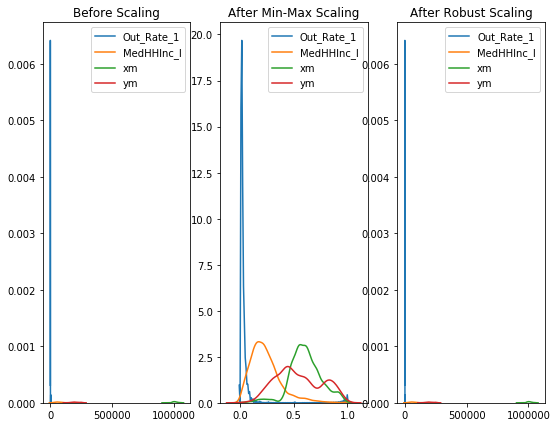

In [90]:
from sklearn import preprocessing
scaler = preprocessing.MinMaxScaler()
scaled_df = scaler.fit_transform(NYCoutagewpop_NANfilewithlatandlong_select)
scaled_df = pd.DataFrame(scaled_df, columns=['Out_Rate_1','MedHHInc_I','xm','ym',])


robustscaler = preprocessing.RobustScaler()
robust_scaled_df = robustscaler.fit_transform(NYCoutagewpop_NANfilewithlatandlong_select)
robust_scaled_df = pd.DataFrame(NYCoutagewpop_NANfilewithlatandlong_select, columns=['Out_Rate_1','MedHHInc_I','xm','ym'])

fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(9,7))

ax1.set_title('Before Scaling')
sn.kdeplot(NYCoutagewpop_NANfilewithlatandlong_select['Out_Rate_1'], ax=ax1)
sn.kdeplot(NYCoutagewpop_NANfilewithlatandlong_select['MedHHInc_I'], ax=ax1)
sn.kdeplot(NYCoutagewpop_NANfilewithlatandlong_select['xm'], ax=ax1)
sn.kdeplot(NYCoutagewpop_NANfilewithlatandlong_select['ym'], ax=ax1)
ax2.set_title('After Min-Max Scaling')
sn.kdeplot(scaled_df['Out_Rate_1'], ax=ax2)
sn.kdeplot(scaled_df['MedHHInc_I'], ax=ax2)
sn.kdeplot(scaled_df['xm'], ax=ax2)
sn.kdeplot(scaled_df['ym'], ax=ax2)
ax3.set_title('After Robust Scaling')
sn.kdeplot(robust_scaled_df['Out_Rate_1'], ax=ax3)
sn.kdeplot(robust_scaled_df['MedHHInc_I'], ax=ax3)
sn.kdeplot(robust_scaled_df['xm'], ax=ax3)
sn.kdeplot(robust_scaled_df['ym'], ax=ax3)

plt.show()

#also tried the normalizer, but it's only used for point data?


Used K nearest neighbors and knee point to find epsilon value for DB SCAN clustering

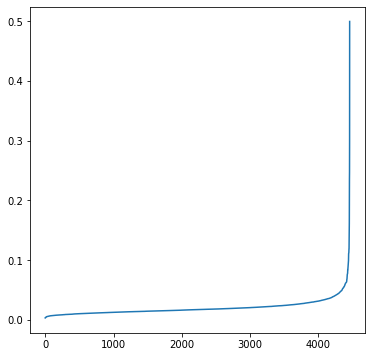

In [92]:
from sklearn.neighbors import NearestNeighbors
neigh=NearestNeighbors(n_neighbors=2)
nbrs=neigh.fit(scaled_df[['Out_Rate_1','MedHHInc_I','xm','ym']])
distances,indices=nbrs.kneighbors(scaled_df[['Out_Rate_1','MedHHInc_I','xm','ym']])
distances=np.sort(distances,axis=0)
distances=distances[:,1]
plt.plot(distances)

0.027777100793958863


<Figure size 360x360 with 0 Axes>

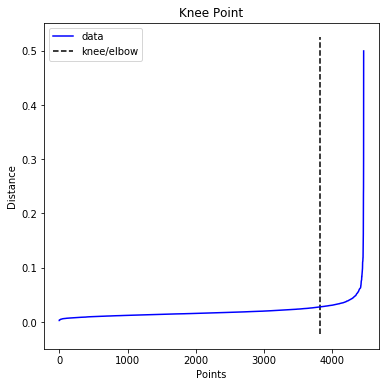

In [93]:
#example of python kneed library to find the knee point of the plot above...
from kneed import KneeLocator, DataGenerator
i = np.arange(len(distances))
knee = KneeLocator(i, distances, S=0, curve='convex', direction='increasing', interp_method='polynomial',online=True)
fig = plt.figure(figsize=(5, 5))
knee.plot_knee()
plt.xlabel("Points")
plt.ylabel("Distance")

print(distances[knee.knee])

In [110]:
from sklearn.cluster import DBSCAN
import sklearn.utils
from sklearn.preprocessing import StandardScaler

epsilon=0.02778 #epsilon value provided by kneelocator above
NYCoutagewpop_cluster4 = scaled_df[['Out_Rate_1','MedHHInc_I','xm','ym']] #ok to use all 4 parameters here?

db=DBSCAN(eps=epsilon,min_samples=3,metric='euclidean').fit(NYCoutagewpop_cluster4)

labels = db.labels_ #tells you which cluster the model assigned to each data point
scaled_df["Clust_Grp4"]=labels #adding new cluster labels column to your dataset

realClusterNum=len(set(labels)) - 1
clusterNum = len(set(labels))
print(realClusterNum) #only created one cluster other than outliers??
print(clusterNum)
#scaled_df.info()
scaled_df.to_csv(r'C:\Users\CHerbert\Downloads\GeoComp2\ElectricalOutageProject\RawData_PowerOutageProjectbyblkgrp\ACS2018wpoeroutages_afterminmaxscalar.csv')

111
112


In [104]:
scaled_df.tail()

,Out_Rate_1,MedHHInc_I,xm,ym,Clust_Grp4
4454,0.011922,0.061890,0.463737,0.325373,22
4455,0.014974,0.238327,0.529935,0.451767,22
4456,0.008546,0.338569,0.530544,0.441717,22
4457,0.013768,0.324327,0.555396,0.464945,22
4458,0.046277,0.441204,0.564862,0.436912,-1


Convert scaled_df from a dataframe back to a geodataframe??
How do I plot x and y values that have been normalized? #x and y values have been normalized and will no longer accurately plot data
gdf = geopandas.GeoDataFrame(df, geometry=geopandas.points_from_xy(df.Longitude, df.Latitude))

In [106]:
#set(labels)

Even though I'm not sure how to plot now that the x's and y's have been normalized, it looks like there have been 111 cluster groups created by the algorithm above..without including outliers

Another example below without including the median household income (just to see how it looks)

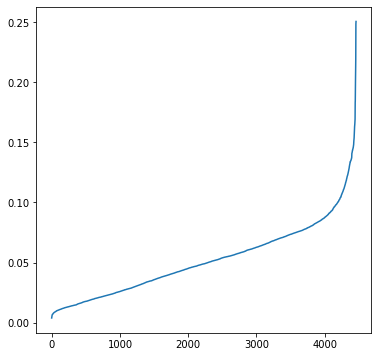

In [107]:
from sklearn.neighbors import NearestNeighbors
neigh=NearestNeighbors(n_neighbors=2)
nbrs=neigh.fit(scaled_df[['MedHHInc_I','xm','ym']])
distances,indices=nbrs.kneighbors(scaled_df[['Out_Rate_1','xm','ym']])
distances=np.sort(distances,axis=0)
distances=distances[:,1]
plt.plot(distances)

0.07802859640625731


<Figure size 360x360 with 0 Axes>

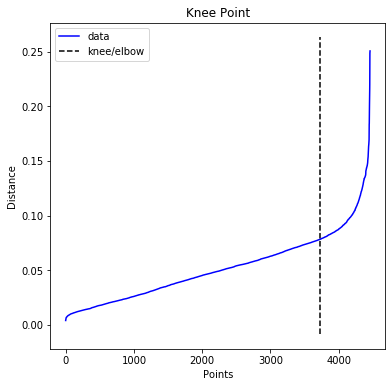

In [108]:
from kneed import KneeLocator, DataGenerator
i = np.arange(len(distances))
knee = KneeLocator(i, distances, S=0, curve='convex', direction='increasing', interp_method='polynomial',online=True)
fig = plt.figure(figsize=(5, 5))
knee.plot_knee()
plt.xlabel("Points")
plt.ylabel("Distance")

print(distances[knee.knee])

In [109]:
from sklearn.cluster import DBSCAN
import sklearn.utils
from sklearn.preprocessing import StandardScaler

epsilon=0.078 #epsilon value provided by kneelocator above
NYCoutagewpop_cluster4 = scaled_df[['Out_Rate_1','xm','ym']] #removed median income this time

db=DBSCAN(eps=epsilon,min_samples=3,metric='euclidean').fit(NYCoutagewpop_cluster4)

labels = db.labels_ #tells you which cluster the model assigned to each data point
scaled_df["Clust_Grp5"]=labels #adding new cluster labels column to your dataset

realClusterNum=len(set(labels)) - 1
clusterNum = len(set(labels))
print(realClusterNum) #only created one cluster other than outliers??
print(clusterNum)
#scaled_df.info()

2
3


Only created 2 clusters this time??